Importamos las librerias necesarias:

In [81]:
#!pip install shapely
import json
import os
import matplotlib
import numpy as np
import pandas as pd

matplotlib.rcParams['font.family'] = 'Times New Roman'

Abrimos los archivos que utilizaremos:

In [165]:
imagenes = './images'
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()
    
data = json.loads(json_data)

Se pueden abrir todas las imagenes o hay alguna corrupta?

In [135]:
def clean_images_and_annotations(data, images_path):
    cleaned_data = []
    corrupt_images = 0
    for item in data:
        image_path = f"{images_path}/{item['item']['name']}"
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                valid_annotations = []
                for annotation in item['annotations']:
                    box = annotation['bounding_box']
                    if 0 <= box['x'] < width and 0 <= box['y'] < height and box['x'] + box['w'] <= width and box['y'] + box['h'] <= height:
                        valid_annotations.append(annotation)
                if valid_annotations:
                    item['annotations'] = valid_annotations
                    cleaned_data.append(item)
        except IOError:
            corrupt_images += 1
    return cleaned_data, corrupt_images


In [136]:
images_path = './images'
cleaned_data, corrupt_images_count = clean_images_and_annotations(data, images_path)
print(f"Imágenes corruptas detectadas: {corrupt_images_count}")


Imágenes corruptas detectadas: 0


Fijemonos las Bounding Boxes en las imagenes con un muestreo aleatorio para ver un panorama general de lo que nos encontramos

Funcion para dibujar las bounding boxes en las imagenes

In [139]:
from PIL import Image, ImageDraw

def draw_bounding_boxes(image_path, annotations):
    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        for annotation in annotations:
            box = annotation['bounding_box']
            x0, y0 = box['x'], box['y']
            x1, y1 = x0 + box['w'], y0 + box['h']
            draw.rectangle([x0, y0, x1, y1], outline='red', width=3)
        plt.imshow(img)
        plt.axis('off')  # No mostrar los ejes para una mejor visualización
        plt.show()


In [ ]:
import random

# Número de imágenes a visualizar
sample_size = 50  # ajusta este número según sea necesario

# Seleccionar muestras aleatorias
sampled_data = random.sample(cleaned_data, min(sample_size, len(cleaned_data)))

# Visualizar las imágenes muestreadas
for item in sampled_data:
    image_path = f"{images_path}/{item['item']['name']}"
    annotations = item['annotations']
    draw_bounding_boxes(image_path, annotations)


En este panorama general podemos ver:

- Plantas sin bounding boxes dibujadas,
- Imagenes claras y obscuras
- Fotos que cortan la fila de plantas a la mitad
- Bounding boxes solapadas

Veamos las imagenes con un numero de bounding boxes inusual

Fijemonos cuáles son las imágenes que están en la carpeta pero no en el jason

In [83]:
import openpyxl

image_names_from_json = [item['item']['name'] for item in data]

image_names_from_json_set = set(image_names_from_json)

image_files = os.listdir(imagenes)

missing_images = []

for image_file in image_files:
    if image_file not in image_names_from_json_set:  
        missing_images.append(image_file)

if missing_images:
    print("Las siguientes imágenes están en la carpeta de imágenes pero no están presentes en el archivo JSON:")
    for image_name in missing_images:
        print(image_name)
else:
    print("Todas las imágenes de la carpeta de imágenes están presentes en el archivo JSON.")

missing_images_count = len(missing_images)
df = pd.DataFrame(missing_images, columns=['Missing Image Names'])
#df.to_excel('C:/Users/sofia/Documents/PROYECTO FINAL/missing_images.xlsx', index=False)

print(f"Hay {missing_images_count} imágenes en la carpeta de imágenes pero no están presentes en el archivo JSON.")

Todas las imágenes de la carpeta de imágenes están presentes en el archivo JSON.
Hay 0 imágenes en la carpeta de imágenes pero no están presentes en el archivo JSON.


Veamos las imagenes con mas y menos bounding boxes en relacion a su ancho sin contar las que no tienen bounding boxes

In [84]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import matplotlib.patches as patches

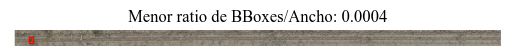

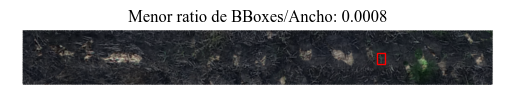

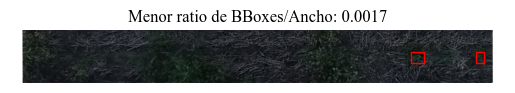

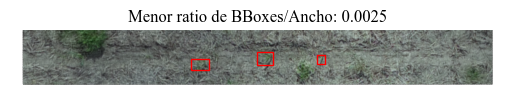

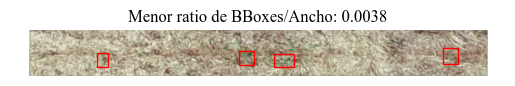

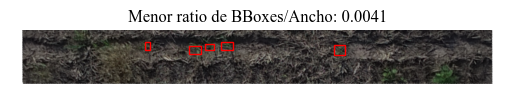

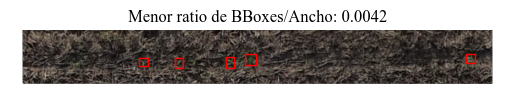

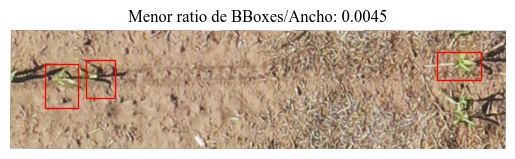

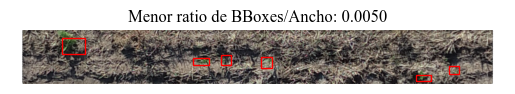

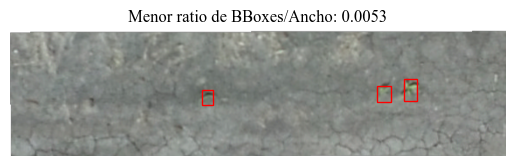

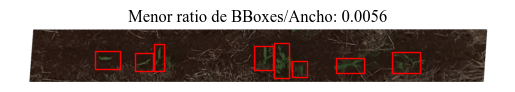

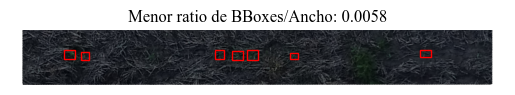

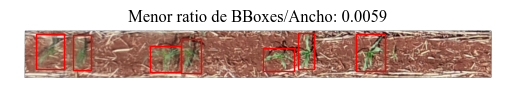

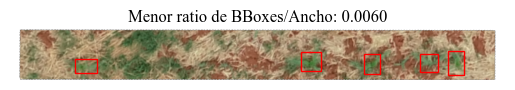

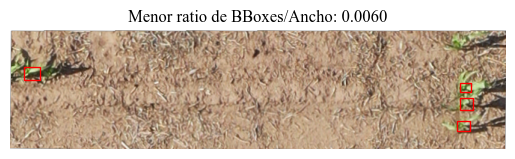

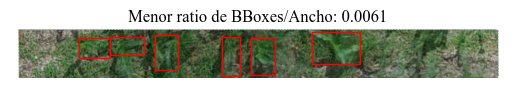

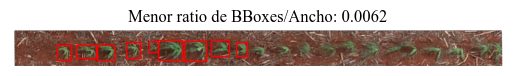

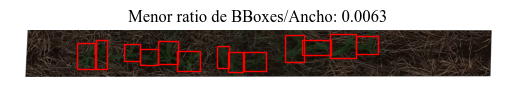

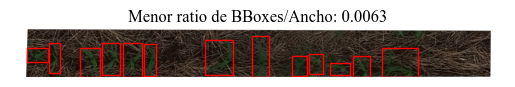

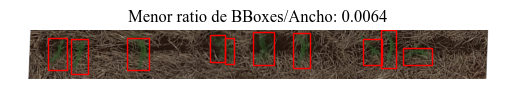

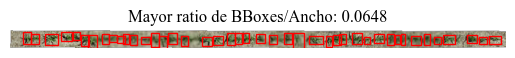

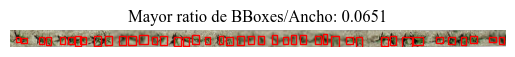

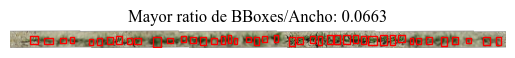

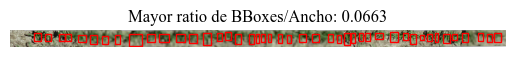

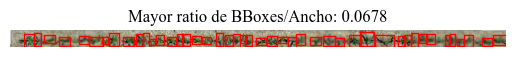

In [129]:
image_bboxes_ratio = []

for item in data:
    annotations = item.get('annotations', [])
    if not annotations:  
        continue

    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_width = item['item']['slots'][0]['width']
    image_bboxes = [(anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h'])
                    for anno in annotations]

    if image_width > 0:
        ratio = len(annotations) / image_width
        image_bboxes_ratio.append((ratio, image_url, image_bboxes))

image_bboxes_ratio.sort(key=lambda x: x[0])
least_images = image_bboxes_ratio[:20]
most_images = image_bboxes_ratio[-5:]

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (x, y, w, h) in bboxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

for ratio, url, bboxes in least_images:
    show_image_with_boxes(url, bboxes, f"Menor ratio de BBoxes/Ancho: {ratio:.4f}")

for ratio, url, bboxes in most_images:
    show_image_with_boxes(url, bboxes, f"Mayor ratio de BBoxes/Ancho: {ratio:.4f}")


Veamos si hay bounding boxes que se solapen a 100%

No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposicion

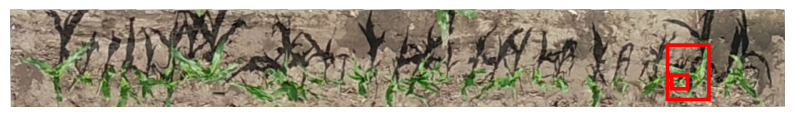

No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposicion

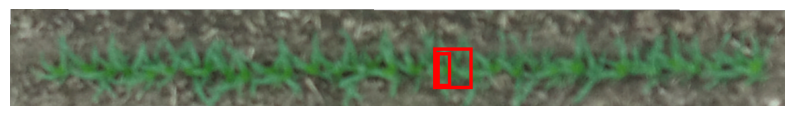

No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposicion

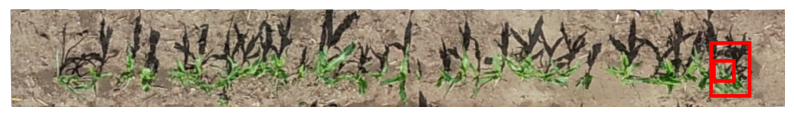

No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposiciones completas en esta imagen.
No hay superposicion

In [152]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def calculate_full_overlap(box1, box2):
    # Verifica si box1 está completamente dentro de box2 o viceversa
    inside_box1 = box1['x'] >= box2['x'] and box1['y'] >= box2['y'] and \
                  (box1['x'] + box1['w']) <= (box2['x'] + box2['w']) and \
                  (box1['y'] + box1['h']) <= (box2['y'] + box2['h'])
    
    inside_box2 = box2['x'] >= box1['x'] and box2['y'] >= box1['y'] and \
                  (box2['x'] + box2['w']) <= (box1['x'] + box1['w']) and \
                  (box2['y'] + box2['h']) <= (box1['y'] + box1['h'])
    
    return inside_box1 or inside_box2

def visualize_full_overlap_boxes(image_path, annotations):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    
    overlapping_boxes = []

    # Buscar pares de bounding boxes que se superponen completamente
    for i in range(len(annotations)):
        for j in range(i + 1, len(annotations)):
            if calculate_full_overlap(annotations[i]['bounding_box'], annotations[j]['bounding_box']):
                overlapping_boxes.append(annotations[i]['bounding_box'])
                overlapping_boxes.append(annotations[j]['bounding_box'])

    if not overlapping_boxes:
        print("No hay superposiciones completas en esta imagen.")
        return

    # Dibuja las bounding boxes que se superponen completamente en rojo
    for box in overlapping_boxes:
        draw.rectangle([box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']], outline="red", width=5)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Ejemplo de uso
if cleaned_data:
    for item in cleaned_data:
        image_path = f"./images/{item['item']['name']}"
        visualize_full_overlap_boxes(image_path, item['annotations'])
else:
    print("No hay datos limpios para visualizar.")


Veamos si hay alguna bounding box que haya sido colocada por error

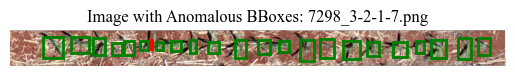

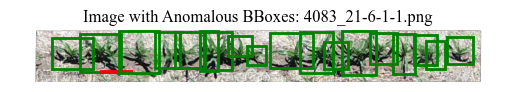

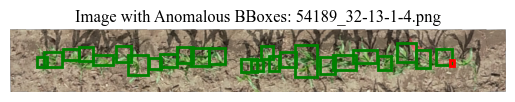

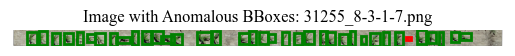

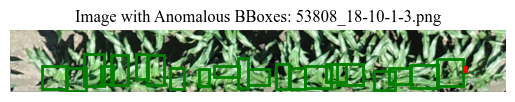

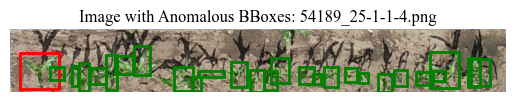

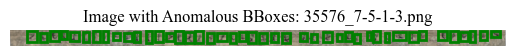

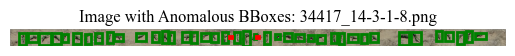

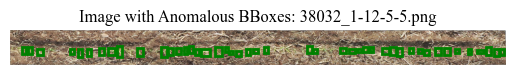

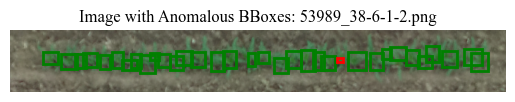

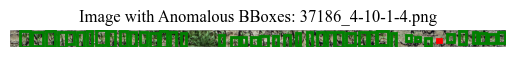

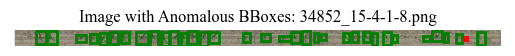

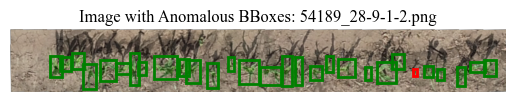

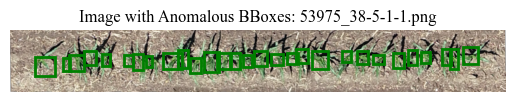

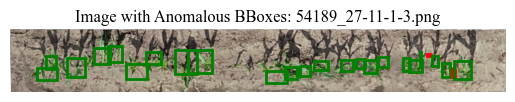

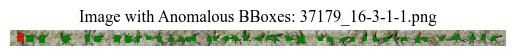

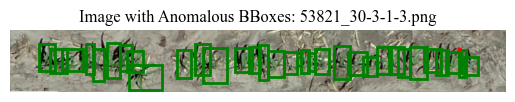

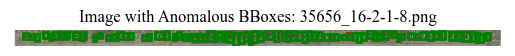

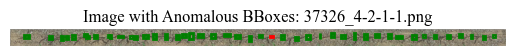

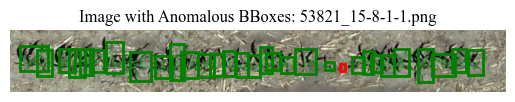

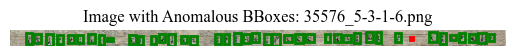

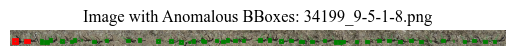

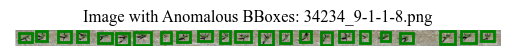

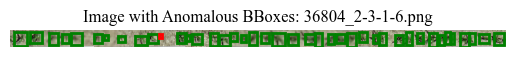

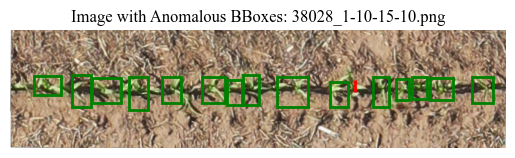

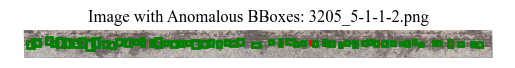

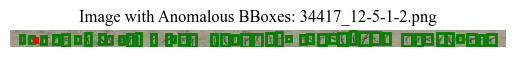

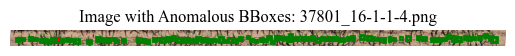

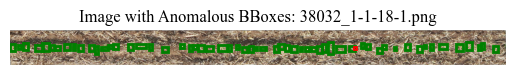

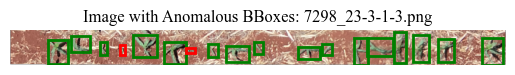

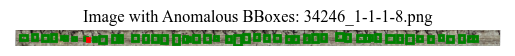

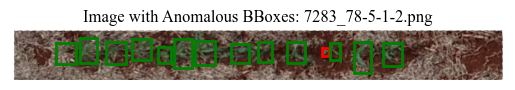

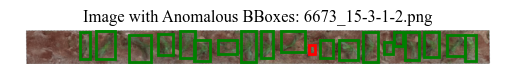

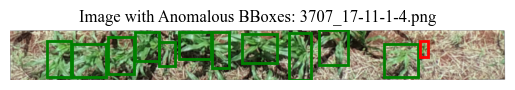

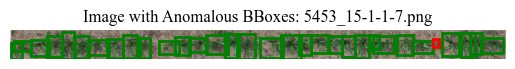

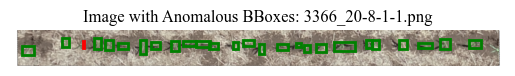

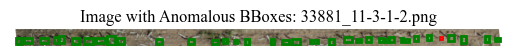

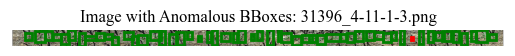

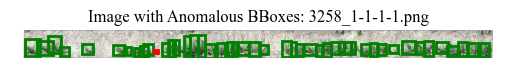

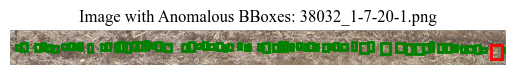

              Image Name                       Bounding Box ID  \
0       7298_3-2-1-7.png  e57f81a3-c211-4a6b-bcf5-1437c02b8d8e   
1      4083_21-6-1-1.png  42562504-de3d-4346-a15a-74e1c5cb20fe   
2    54189_32-13-1-4.png  dc12e8ba-5392-4455-97fb-e48313c9cf23   
3      31255_8-3-1-7.png  146dfb18-a3ee-4ccb-ba15-5ebc7892c744   
4    53808_18-10-1-3.png  19608194-31f4-4118-846d-07a2c55e1f1f   
5    53808_18-10-1-3.png  606421f8-2eaa-4685-aff0-32fea305fbe3   
6     54189_25-1-1-4.png  0cea9687-7c61-4846-a801-a898f929e9fb   
7      35576_7-5-1-3.png  8008dbd3-749f-48ac-bb12-ce9040bbf683   
8     34417_14-3-1-8.png  560c01f9-c130-4ce3-ac89-070d313fd6af   
9     34417_14-3-1-8.png  5b8d1ff9-cc87-451b-82c1-d2bb84a0dc6c   
10    38032_1-12-5-5.png  8cff1ed5-ae2b-41c0-9275-ca7d05ed5da1   
11    53989_38-6-1-2.png  38c8fb8b-5d80-449b-a8c3-6ca0db5d5bfd   
12    37186_4-10-1-4.png  256ec6c4-302a-4011-ab78-400dd0817fde   
13    34852_15-4-1-8.png  fd8b4b16-14da-48e6-9ac4-a4f23e7bdf2c   
14    5418

In [16]:
anomalous_data = []

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (bbox_id, x, y, w, h, anomalous) in bboxes:
        color = 'r' if anomalous else 'g'
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

for item in data:
    annotations = item['annotations']
    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_name = item['item']['name']

    areas = []
    bboxes_details = []
    for anno in annotations:
        x, y, w, h = anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h']
        bbox_id = anno['id']
        area = w * h
        areas.append(area)
        bboxes_details.append((bbox_id, x, y, w, h))

    if areas:
        median_area = np.median(areas)
        threshold_upper = 5 * median_area
        threshold_lower = 0.15 * median_area

        annotated_bboxes = []
        show = False
        for (bbox_id, x, y, w, h), area in zip(bboxes_details, areas):
            anomalous = area > threshold_upper or area < threshold_lower
            annotated_bboxes.append((bbox_id, x, y, w, h, anomalous))
            if anomalous:
                anomalous_data.append({
                    'Image Name': image_name,
                    'Bounding Box ID': bbox_id,
                    'Anomalous Area': area,
                    'Median Area': median_area
                })
                show = True

        if show:
            show_image_with_boxes(image_url, annotated_bboxes, f"Image with Anomalous BBoxes: {image_name}")

df_anomalous_images = pd.DataFrame(anomalous_data)
print(df_anomalous_images)

# Save the dataframe to a CSV file
df_anomalous_images.to_csv('./anomalous_images_details.csv', index=False)


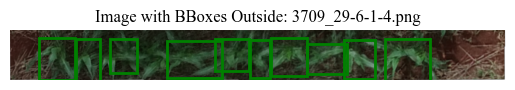

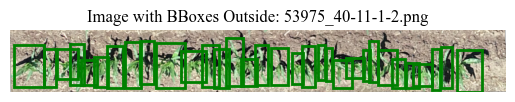

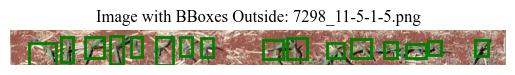

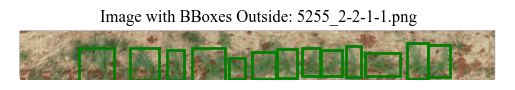

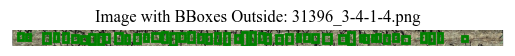

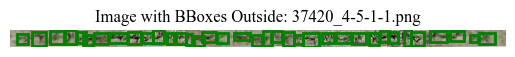

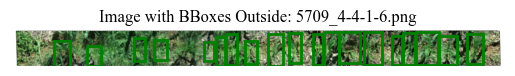

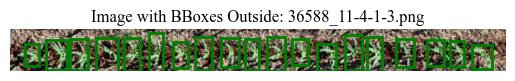

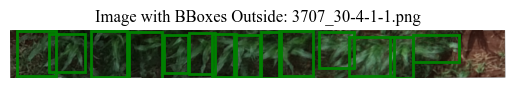

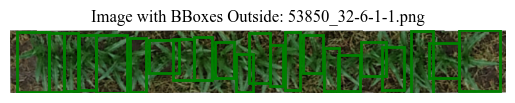

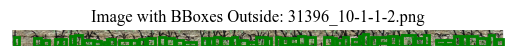

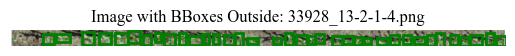

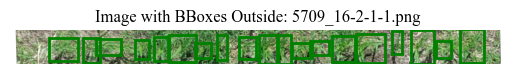

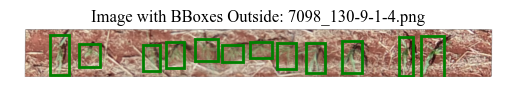

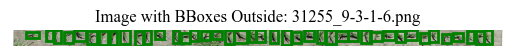

KeyboardInterrupt: 

In [116]:
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import BytesIO

def check_bboxes_outside_image(bboxes, image_width, image_height):
    bboxes_outside = []
    for (bbox_id, x, y, w, h, anomalous) in bboxes:
        if x < 0 or y < 0 or (x + w) > image_width or (y + h) > image_height:
            bboxes_outside.append(bbox_id)
    return bboxes_outside

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (bbox_id, x, y, w, h, anomalous) in bboxes:
        color = 'r' if anomalous else 'g'
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

bboxes_outside_data = []

for item in data:
    annotations = item['annotations']
    image_width = item['item']['slots'][0]['width']
    image_height = item['item']['slots'][0]['height']
    image_name = item['item']['name']
    image_url = item['item']['slots'][0]['source_files'][0]['url']

    bboxes_details = []
    for anno in annotations:
        x, y, w, h = anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h']
        bbox_id = anno['id']
        bboxes_details.append((bbox_id, x, y, w, h))

    if bboxes_details:
        annotated_bboxes = []
        for (bbox_id, x, y, w, h) in bboxes_details:
            annotated_bboxes.append((bbox_id, x, y, w, h, False))

        bboxes_outside = check_bboxes_outside_image(annotated_bboxes, image_width, image_height)
        if bboxes_outside:
            bboxes_outside_data.append({
                'Image Name': image_name,
                'Bounding Boxes Outside Image': bboxes_outside
            })
            show_image_with_boxes(image_url, annotated_bboxes, f"Image with BBoxes Outside: {image_name}")

for item in bboxes_outside_data:
    print("Image Name:", item['Image Name'])
    print("Bounding Boxes Outside Image:", item['Bounding Boxes Outside Image'])

